# Chapter 7 fully illustrated using Jove

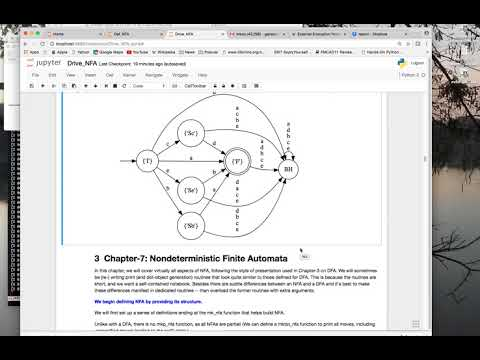

In [1]:
# PLAY this Youtube to know how to use the contents of this file + follow some of the Def_DFA.ipynb defns

from IPython.display import YouTubeVideo
YouTubeVideo('xjFtLF95uBc')

In [2]:
from jove.DotBashers import *
from jove.Def_md2mc import *
from jove.Def_NFA   import *
from jove.Def_DFA   import *
from jove.Def_RE2NFA    import *
from jove.Def_NFA2RE    import *

You may use any of these help commands:
help(ResetStNum)
help(NxtStateStr)

You may use any of these help commands:
help(md2mc)
.. and if you want to dig more, then ..
help(default_line_attr)
help(length_ok_input_items)
help(union_line_attr_list_fld)
help(extend_rsltdict)
help(form_delta)
help(get_machine_components)

You may use any of these help commands:
help(mkp_dfa)
help(mk_dfa)
help(totalize_dfa)
help(addtosigma_delta)
help(step_dfa)
help(run_dfa)
help(accepts_dfa)
help(comp_dfa)
help(union_dfa)
help(intersect_dfa)
help(pruneUnreach)
help(iso_dfa)
help(langeq_dfa)
help(same_status)
help(h_langeq_dfa)
help(fixptDist)
help(min_dfa)
help(pairFR)
help(state_combos)
help(sepFinNonFin)
help(bash_eql_classes)
help(listminus)
help(bash_1)
help(mk_rep_eqc)
help(F_of)
help(rep_of_s)
help(q0_of)
help(Delta_of)
help(mk_state_eqc_name)

You may use any of these help commands:
help(mk_nfa)
help(totalize_nfa)
help(step_nfa)
help(run_nfa)
help(ec_step_nfa)
help(Eclosure)
help(Echelp)
help(accept

An NFA is a machine $(Q, \Sigma, \delta, Q_0, F)$ which is somewhat like a DFA 
except that 

1. It can start from a __set__ of starting states $Q_0$
    > i.e., the NFA can start from more than one starting state
    
2. Its transition function $\delta$ maps $Q\times (\Sigma\cup \{\varepsilon\})$ to $2^{Q}$
    > i.e., the NFA takes a state $Q$ and a symbol and returns a set of states
    
You can see these aspects being illustrated in the NFA to follow

# Limitations of DFA

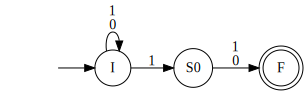

In [3]:
secondlast = md2mc('''
NFA
I  : 0 -> I
I  : 1 -> I, S0
S0 : 0 | 1 -> F
''')
dotObj_nfa(secondlast, FuseEdges=True)

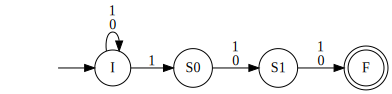

In [4]:
thirdlast = md2mc('''
NFA
I  : 0 -> I
I  : 1 -> I, S0
S0 : 0 | 1 -> S1
S1 : 0 | 1 -> F
''')
dotObj_nfa(thirdlast, FuseEdges=True)

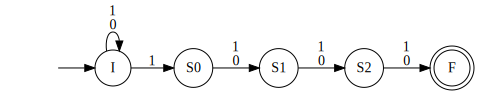

In [5]:
fourthlast = md2mc('''
NFA
I  : 0 -> I
I  : 1 -> I, S0
S0 : 0 | 1 -> S1
S1 : 0 | 1 -> S2
S2 : 0 | 1 -> F
''')
dotObj_nfa(fourthlast, FuseEdges=True)

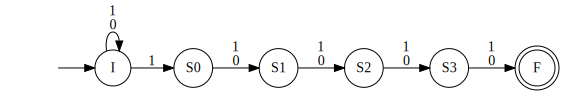

In [6]:
fifthlast = md2mc('''
NFA
I  : 0 -> I
I  : 1 -> I, S0
S0 : 0 | 1 -> S1
S1 : 0 | 1 -> S2
S2 : 0 | 1 -> S3
S3 : 0 | 1 -> F
''')
dotObj_nfa(fifthlast, FuseEdges=True)

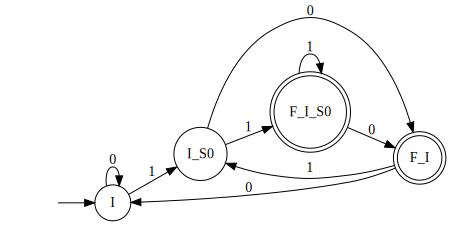

In [7]:
dotObj_dfa(min_dfa(nfa2dfa(secondlast)))

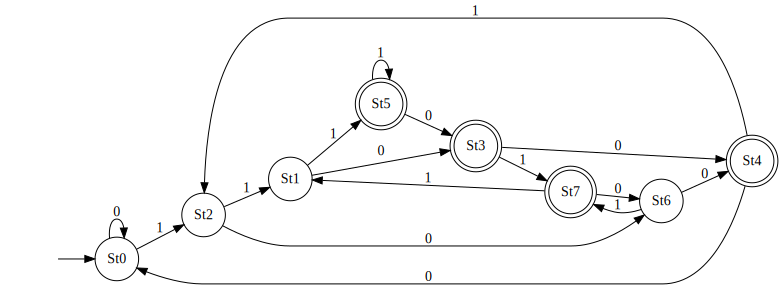

In [8]:
dotObj_dfa(min_dfa(nfa2dfa(thirdlast)))

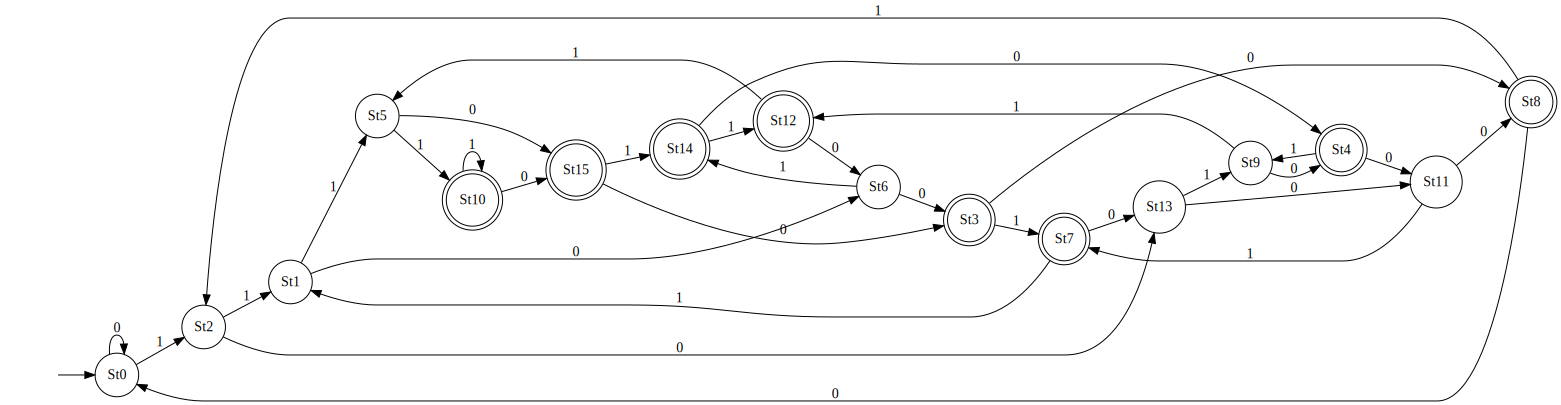

In [9]:
dotObj_dfa(min_dfa(nfa2dfa(fourthlast)))

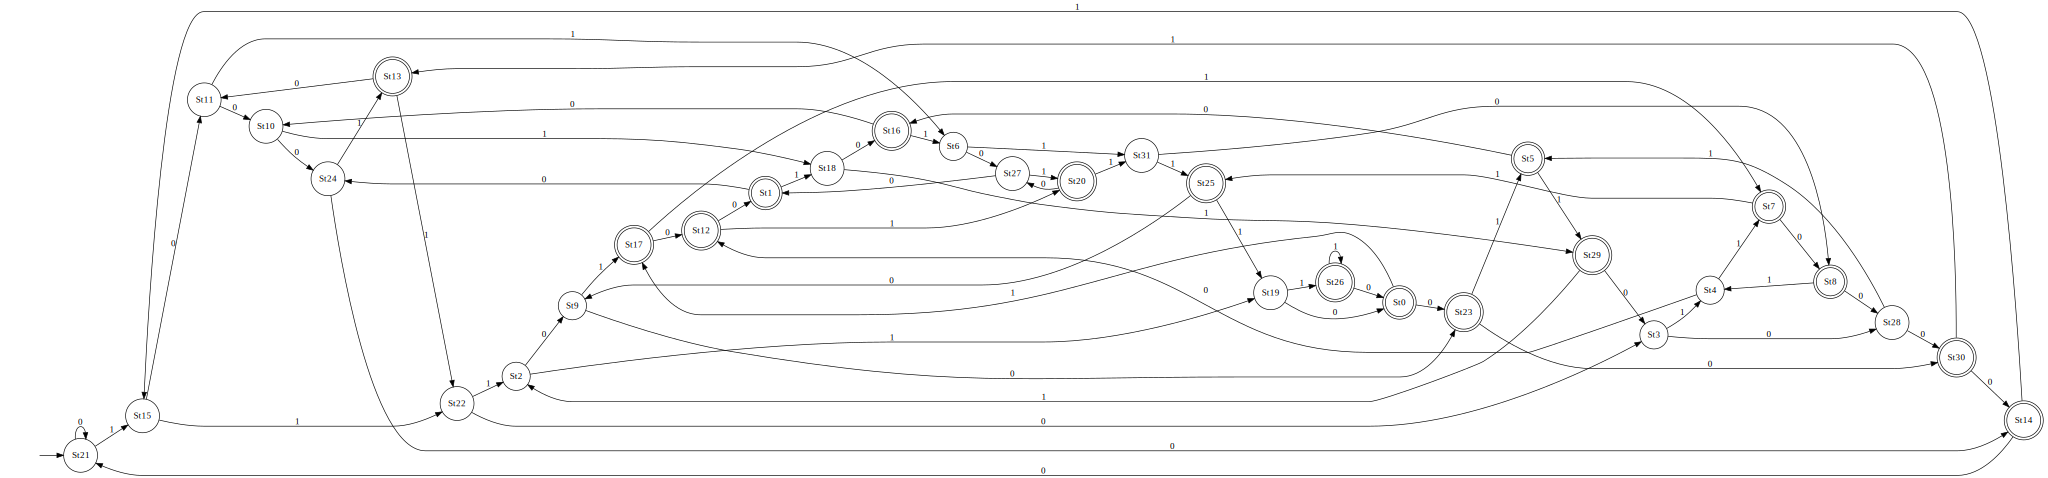

In [10]:
dotObj_dfa(min_dfa(nfa2dfa(fifthlast)))

In [11]:
len(min_dfa(nfa2dfa(secondlast))["Q"])

4

In [12]:
len(min_dfa(nfa2dfa(thirdlast))["Q"])

8

In [13]:
len(min_dfa(nfa2dfa(fourthlast))["Q"])

16

In [14]:
len(min_dfa(nfa2dfa(fifthlast))["Q"])

32

## Clear evidence of exponential blowup!

### Another problem with DFA : No natural way to specify many languages

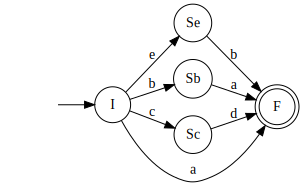

In [15]:
# NFA for the language {'a','ba','cd','eb'}
nfa_abcde = md2mc('''
NFA
I   : a -> F
I   : b -> Sb
Sb  : a -> F
I   : c -> Sc
Sc  : d -> F
I   : e -> Se
Se  : b -> F
''')
dotObj_nfa(nfa_abcde)

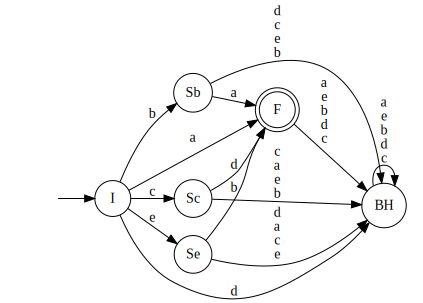

In [16]:
# With DFA we do something else (build DFA for 'a' with alphabet being {a,b,c,d,e} etc...)
# This results in this DFA
dotObj_dfa_w_bh(min_dfa(nfa2dfa(nfa_abcde)), FuseEdges=True)

# Chapter-7: Nondeterministic Finite Automata

In this chapter, we will cover virtually all aspects of NFA, following the style of presentation used in Chapter-3 on DFA. We will sometimes be (re-) writing print (and dot-object generation) routines that look quite similar to those defined for DFA. This is because the routines are short, and we want a self-contained notebook. Besides there are subtle differences between an NFA and a DFA and it's best to make these differences manifest in dedicated routines -- than overload the former routines with extra arguments. 

<span style="color:blue"> **We begin defining NFA by providing its structure. ** </span>

We will first set up a series of definitions ending at the mk_nfa function that helps build NFA. 

Unlike with a DFA, there is no mkp_nfa function, as all NFAs are partial! (We can define a mktot_nfa function to print all moves, including unspecified moves leading to the se({}) state.)

We will define step_nfa, run_nfa and accepts_nfa which are key functions that clearly spell out how NFA differ from DFA.

We will also be defining functions for displaying NFA with the help of the _dot_ tool. The design will be similar to that with DFA.

<span style="color:blue"> **------** </span>

<span style="color:red"> __We will follow Kozen and endow an NFA with multiple start states __ </span>



This will allow the NFA to be more naturally handled. For instance, the reverse of a DFA is an NFA. When we reverse a DFA, all its final states become initial states of the NFA (that models the reversed language). There are 2 ways to handle this:

1. Introduce a fake new initial state and jump from it via $\varepsilon$ onto (what were the final state of the DFA).

2. Don't introduce the fake new initial state, but rather allow the NFA to start from all of F being really its start state.

    * Of course, in almost all situations, this is a minor difference
    
    * But to enjoy the topic as completely as one can, it is best to be "clean" and follow clean definitions.
    
        - I've seen Ed Clarke also use multiple initial states
        
        - Hence our code will be for this relaxed setup
        
        - Of course if you __REALLY__ wanted to have only one start state, then make it a singleton set of states and work that through your NFA.


<br>

__So now, following Brzozowski, we have__

<br>

An NFA is a quintuple $(Q,\Sigma,\delta,Q_0,F)$, where:

* $Q$ is a _finite nonempty_ set of states.

* $\Sigma$ is a _finite nonempty_ alphabet containing _symbols_.

* $\delta$ is a (partial)
	transition function, containing a set of _transitions_. The transitions take
    a pair from $Q\times \Sigma$ and return a __subset__ of states in $Q$. All this is succinctly
    captured by writing
    $\delta: Q\times \Sigma \rightarrow 2^Q$. 
    Here we use $2^Q$ to denote the powerset of $Q$.
    
  
* $Q_0\subseteq Q$, is __a set of initial states__.  Notice that we change from q0 (or $q_0$) which is what you find books such as Sipser and Linz using.


* $F\subseteq Q$ is a _finite_ (and _possibly empty_) set of
	final (or _accepting_) states. These are shown as double-circled nodes in the graph of a DFA. 
 
> There is no other change. I.e. $\delta$ remains the same as before.
> It is that when an NFA starts, it can find itself in a set of start states.
> Most NFAs start from a __singleton__ Q0, which is then, effectively, an NFA
 that matches most books say.

Some terminology:

> We call $Q$,$\Sigma$, $\delta$, $Q_0$, and $F$ the **_traits_** of the NFA.

> We will call an NFA **_structurally consistent_** or simply **"consistent"** if its traits pass the aforesaid checks.


Here is how the checks will be broken down:

* The supplied $\delta$ function will be checked to see if it has allowed domain and range points. 
 - The domain points must be a subset of $Q\times \Sigma$
 - The range points must be a subset of $2^Q$
  We do no insist that the supplied $\delta$ be total.
    
* $Q_0\subseteq Q$, is _the_ initial state.

* $F\subseteq Q$ is a _finite_ (and _possibly empty_) set of
	final (or _accepting_) states.  
    
We will often use the state set({}) to be the equivalent of a black-hole state for an NFA.

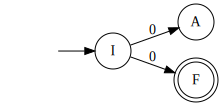

In [17]:
nfa1 = md2mc('''NFA
I : 0 -> A
I : 0 -> F''')
dotObj_nfa(nfa1)

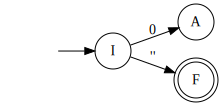

In [18]:
nfa2 = md2mc('''NFA
I : '' -> F
I : 0  -> A
''')
dotObj_nfa(nfa2)

# The $\delta$ function of the NFA

In [19]:
help(step_nfa)

Help on function step_nfa in module jove.Def_NFA:

step_nfa(N, q, c)
    In : N (consistent NFA)
         q (state in N)
         c (symbol in N's sigma or "")
    Out: The set of states reached via N's Delta.
    EClosure is NOT performed.
    If the move is not defined, return {}.



In [20]:
step_nfa(nfa1, 'I', '')

set()

In [21]:
step_nfa(nfa1, 'I', '0')

{'A', 'F'}

In [22]:
step_nfa(nfa2, 'I','')

{'F'}

In [23]:
fig71a = md2mc('''
NFA
I  : 0 -> I
I  : 1 -> I, S0
S0 : 0 | 1 -> S1
S1 : 0 | 1 -> F
''')

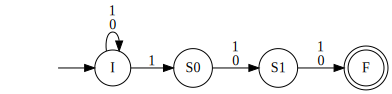

In [24]:
dotObj_nfa(fig71a, FuseEdges=True)

In [25]:
fig71b = md2mc('''
NFA
I  : 0 | 1 -> I
I  : '' -> S0
S0 : 1  -> S1
S1 : 0 | 1 -> S2
S2 : 0 | 1 -> F
''')

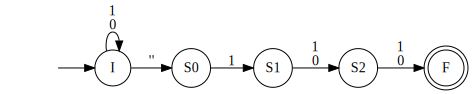

In [26]:
dotObj_nfa(fig71b, FuseEdges=True)

# Stepping and Running NFA

Now that we've defined NFA and allied actions such as consistency checking and printing, let's write functions to step and run them.

* How the state transition function $\delta$ "works"
  - captured in step_nfa

In [27]:
help(step_nfa)

Help on function step_nfa in module jove.Def_NFA:

step_nfa(N, q, c)
    In : N (consistent NFA)
         q (state in N)
         c (symbol in N's sigma or "")
    Out: The set of states reached via N's Delta.
    EClosure is NOT performed.
    If the move is not defined, return {}.



In [28]:
step_nfa(fig71b, "I", '')

{'S0'}

In [29]:
step_nfa(fig71b, "S0", '')

set()

In [30]:
step_nfa(fig71b, "I", '0')

{'I'}

In [31]:
help(run_nfa)

Help on function run_nfa in module jove.Def_NFA:

run_nfa(N, S, s, chatty=False)
    In : N (consistent NFA)
         S (SET of states S belonging to N's states)
         s (string over N's alphabet)
    Out: SET of states reached after processing s.
    Run the NFA starting with a SET of states S on string,
    with EClosure wherever necessary. Return set of states reached.



In [32]:
run_nfa(fig71b, "I", "0")

{'I', 'S0'}

In [33]:
run_nfa(fig71b, "I", "0", chatty=True)

States reached =  {'S0', 'I'}


{'I', 'S0'}

In [34]:
step_nfa(fig71b, "I", '1')

{'I'}

In [35]:
run_nfa(fig71b, "I", '1')

{'I', 'S0', 'S1'}

In [36]:
run_nfa(fig71b, {"I"}, "")

{'I', 'S0'}

In [37]:
Eclosure(fig71b, {"I"})

{'I', 'S0'}

# The EClosure Function (defined on a set of states)

In [38]:
run_nfa(fig71b, {"I"}, "0101")

{'F', 'I', 'S0', 'S1'}

In [39]:
run_nfa(fig71b, {"I"}, "0101", True)

States reached =  {'S0', 'I'}
States reached =  {'S0', 'S1', 'I'}
States reached =  {'S2', 'S0', 'I'}
States reached =  {'F', 'S0', 'S1', 'I'}


{'F', 'I', 'S0', 'S1'}

In [40]:
import ipywidgets as wdg
def run_nfa_slider(firstTime, N, s, n):
    """Run NFA N from N["Q0"] (which is a set..) on substring s[0:n]
    """
    if firstTime:
        print("Eclosure of N's start state is")
        print(Eclosure(N, N["Q0"]))
        firstTime = False
    S = N["Q0"] 
    if (n > len(s)):
        n = len(s)
    print("string = ", s[0:n])
    run_nfa(N, S, s[0:n], True)
    
def run_nfa_int(N1, N2):
    """Run interactively from the given NFA .. from {q0} 
       on input string's substring
       as picked by slider.
    """
    inp = input("Please provide string: ")
    wdg.interact(run_nfa_slider, firstTime=True, N = {'N1': N1, 'N2': N2}, 
                 s = inp, n=(0,32) )

In [41]:
run_nfa_int(fig71a, fig71b)

Eclosure of N's start state is
{'I'}
string =  01001
States reached =  {'I'}
States reached =  {'S0', 'I'}
States reached =  {'S1', 'I'}
States reached =  {'F', 'I'}
States reached =  {'S0', 'I'}


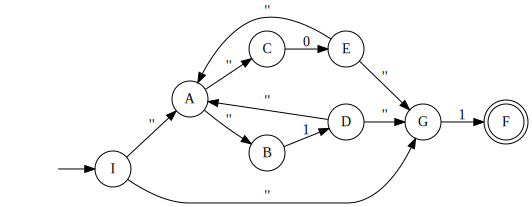

In [42]:
fig74a = md2mc('''
NFA
I : '' -> A, G
A : '' -> B, C
B : 1  -> D
C : 0  -> E
D : '' -> A, G
E : '' -> A, G
G : 1  -> F
''')
dotObj_nfa(fig74a)

In [43]:
run_nfa_int(fig74a, fig71b)

Eclosure of N's start state is
{'A', 'B', 'C', 'G', 'I'}
string =  01000
States reached =  {'E', 'A', 'B', 'C', 'G'}
States reached =  {'D', 'F', 'A', 'B', 'C', 'G'}
States reached =  {'E', 'A', 'B', 'C', 'G'}
States reached =  {'E', 'A', 'B', 'C', 'G'}
States reached =  {'E', 'A', 'B', 'C', 'G'}


# DFA to NFA conversion (!)

This is a useful helper and helps understand the theory, but not widely used.
Its main use is within "NFA2RE". Suppose you want to convert a DFA to an RE? 
Then use dfa2nfa and then NFA2RE :-)

In [44]:
def dfa2nfa(D):
    """Given a DFA D, make a language-equivalent NFA.
    """
    assert(
    is_partially_consistent_dfa(D)
    ), "DFA given to dfa2nfa is not part. consist."
    return { "Q"     : D["Q"],
             "Sigma" : D["Sigma"],
             "Delta" : dict((a,{b}) for (a,b) in D["Delta"].items()),
             "Q0"    : { D["q0"] },
             "F"     : D["F"] }  

# NFA to DFA conversion


* Input: An NFA, N

* Output: A language-equivalent DFA, D

* Method: Subset Construction

  - Data structure to maintain : 
  
    * A set called "Unexpanded" (UNEXP for short), which holds SETS of states of the given NFA, N
    
    * These serve as the states of the DFA (D) being built
    
      - Note that UNEXP is a set of state-sets (set of 'set-of-states' if you will)

> * Let INIT = D["q0"] (DFA's initial state) =  Eclosure of N["Q0"]  

> * Add INIT to UNEXP

---
  
> WHILE (UNEXP $\neq \emptyset$) DO

> > Choose a state S from UNEXP

> > Delete S from UNEXP

> > Expand(S)   --   Expand(S) will add all the 'c' moves out of S where c $\in \Sigma$

> END WHILE 

** Expand(S): **

> For each symbol $c$ in $\Sigma$

> > For each state s ∈ S do  --  Recall that S is a set of states

> > > Let $NS_c$ = $\delta(s,c)$ --  Find the next __set of states__ the NFA can be, starting from s, moving on c 

> > > Let $NSE_c$ = Eclose($NS_c$)   --  Eclose $NS_c$ which means Eclose every state in $NS_c$ and union them

> > > Introduce a transition in D from S to $NSE_c$

> > If $NSE_c$ does not exist in the DFA D, add it to UNEXP

** Eclose(S): **

> For each state $x \in S$:

> > Move $x$ through $\varepsilon$, obtaining a set of next state $S_x$

> Union these $S_x$ and return that union

# The Actual NFA 2 DFA Conversion Code

In [45]:
def nfa2dfa(N):
    """In : N (consistent NFA)
       Out: A consistent DFA that is language-equivalent to N.
    """
    assert(
        is_consistent_nfa(N)
    ), "nfa2dfa was given an inconsistent NFA."
    # EClose the starting state of the NFA
    EC = Eclosure(N, N["Q0"])
    return n2d(Frontier=[EC], Visited=[EC], Delta=dict({}), Nfa=N)


def n2d(Frontier, Visited, Delta, Nfa):
    """Helper for nfa2dfa.
       ---
       In : Frontier (list of state sets; initially Eclosed Q0)
            Visited  (list of visited state sets; initially Eclosed Q0)
            Delta    (the DFA transition function being formed)
            Nfa      (the NFA being converted)
       Helper to nfa2dfa. Given a (BFS) frontier, a Visited
       set of states, the Delta being formed, and NFA Nfa, see
       if all new moves are in Visited:
         do last gasp of Delta update; make and return a DFA;
       else: extend Frontier, Visited, Delta; recurse.
    """
    All_c_Moves = [ ((Q,c),ec_step_nfa(Nfa,Q,c)) 
                   for Q in Frontier 
                   for c in Nfa["Sigma"] ]
    New_c_Moves = list(filter(lambda QcQ: trTrg(QcQ) not in Visited, 
                              All_c_Moves))  
    if New_c_Moves == []:
        # Add last-gasp c-moves that curl back!
        last_gasp_c_moves = dict([ ((mkSSnam(Qfrom),c),mkSSnam(Qto)) 
                                  for ((Qfrom, c), Qto) in All_c_Moves ])
        Delta.update(last_gasp_c_moves)
                  
        # DFA states are visited states
        DFA_Q = { mkSSnam(Q) for Q in Visited }
                  
        # Retain alphabet
        DFA_Sigma = Nfa["Sigma"]
                  
        # Delta is ready to go
        DFA_Delta = Delta
                  
        # DFA starts at Eclosure of Nfa's Q0 set of states
        DFA_q0 = mkSSnam(Eclosure(Nfa, Nfa["Q0"]))
                  
        # DFA's final states are those in visited that contain an NFA 
        # F-state but don't retain any empty sets, in case the NFA given 
        # has no F-states!
        # This is another corner-case (i.e. don't shove-in black hole 
        # states!)
        DFA_F = set(map(lambda Q: mkSSnam(Q), 
                        filter(lambda Q: (Nfa["F"]&Q) != set({}), 
                               Visited)))
                  
        # Make the DFA; send it to the DFA-shrink to bask ugly long 
        # state names...
        return shrink_dfastates(mk_dfa(DFA_Q, 
                                       DFA_Sigma, 
                                       DFA_Delta, 
                                       DFA_q0, 
                                       DFA_F))
    else:
        newFrontier = list(map(lambda QcQ: trTrg(QcQ), New_c_Moves)) 
        newVisited = Visited + newFrontier
                  
        # Even though the NFA has not closed back on itself, we MUST 
        # accommodate for the "curl-backs" along the way !!  Thus, run it
        # over All_c_Moves which may include "partial revisits along the 
        # way". We MUST pick up those curl-backs!
        NewMovesDelta = dict([ ((mkSSnam(Qfrom),c),mkSSnam(Qto)) 
                              for ((Qfrom, c), Qto) in All_c_Moves ]) 
        Delta.update(NewMovesDelta)
        return n2d(newFrontier, newVisited, Delta, Nfa)
                                  
#---NFA to DFA

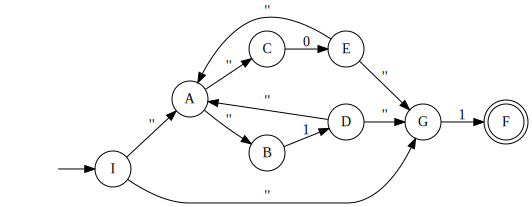

In [46]:
fig74a = md2mc('''
NFA
I : '' -> A, G
A : '' -> B, C
B : 1  -> D
C : 0  -> E
D : '' -> A, G
E : '' -> A, G
G : 1  -> F
''')
dotObj_nfa(fig74a)

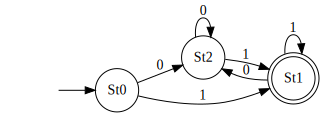

In [47]:
dotObj_dfa(nfa2dfa(fig74a))

# Brzozowski's DFA Minimization

Picking up from our earlier discussions, to minimize a DFA using Brzozowski's algorithm, here are the steps:

* Make sure that the given DFA has no unreachable states
* Reverse the DFA
* Determinize it
* Reverse that DFA
* Determinize it

Thus we need to write a routine to reverse a DFA. We already have a way to ensure that a DFA does not have unreachable states (in another Jupyter notebook; we won't bother to include it here, and trust the user to always provide such DFA only).

We can observe that if a DFA has black-hole states, then those states won't matter in the reversed machine (reversed NFA). Thus, we can work with __partial__ dfa (i.e., DFA that are partially consistent).

## DFA reversal

In [48]:
def inSets(D,trg,ch):
    """In : D   = partially consistent dfa,
            trg = a target state in D["q"]
            ch  = a member of D["Sigma"]
       Out: a set of states. { q s.t. Delta[q,ch] == trg }
    """
    return { q for q in D["Q"] if D["Delta"][(q,ch)] == trg }

def rev_dfa(D):
    """In : D = a partially consistent DFA without any unreachable states.
       Out: A consistent NFA whose language is D's language reversed.
    """
    # 1. Given that NFAs start from a SET of states, we already have that
    #   info. No need to add any transitions from "a new initial state" 
    #   etc
    
    # 2. Now add the inSets of each state as the NFA next set of states
    NDict = { (q,ch) : inSets(D,q,ch) 
              for q in D["Q"] 
              for ch in D["Sigma"] }
    
    # Notice that we retain D["Q"] and start from Q0 = D["F"]
    # going backwards along NDict toward F_dfa = { D["q0"] }
    return mk_nfa(D["Q"], D["Sigma"], NDict, D["F"], {D["q0"]})

In [49]:
nfaMultiQ0 = md2mc('''
NFA
I0 : a | b | c -> A, B
I0 : c -> F
I1 : a | b -> A, B
A  : c -> F
B  : d -> F
''')

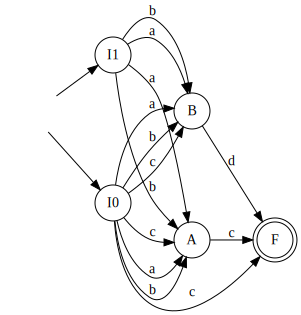

In [50]:
dotObj_nfa(nfaMultiQ0)

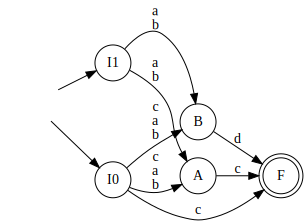

In [51]:
dotObj_nfa(nfaMultiQ0, FuseEdges=True)

In [52]:
dfaMQ0 = nfa2dfa(nfaMultiQ0)

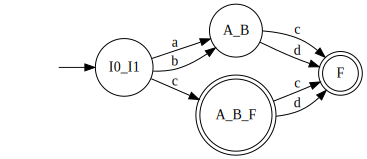

In [53]:
dotObj_dfa(dfaMQ0)

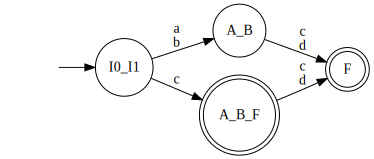

In [54]:
dotObj_dfa(dfaMQ0, FuseEdges=True)

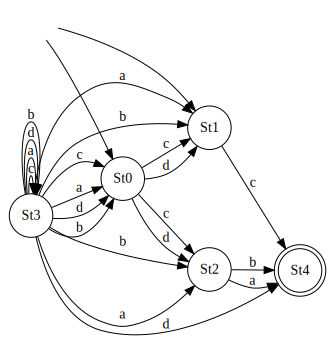

In [55]:
dotObj_nfa(rev_dfa(dfaMQ0))

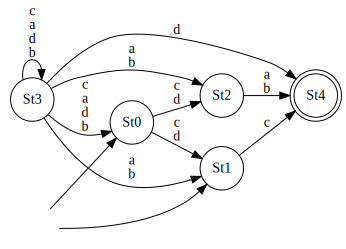

In [56]:
dotObj_nfa(rev_dfa(dfaMQ0), FuseEdges=True)

In [57]:
help(min_dfa_brz)

Help on function min_dfa_brz in module jove.Def_NFA:

min_dfa_brz(D)
    Minimize a DFA as per Brzozowski's algorithm.



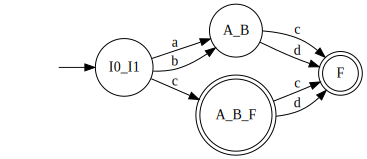

In [58]:
dotObj_dfa(dfaMQ0)

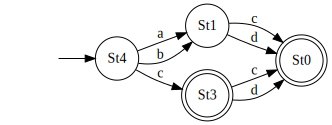

In [59]:
dotObj_dfa(min_dfa_brz(dfaMQ0))

# Brzozowski Minimization : All Steps 

In [60]:
blimp = md2mc('''
DFA 
I1 : a -> F2
I1 : b -> F3
F2 : a -> S8
F2 : b -> S5
F3 : a -> S7
F3 : b -> S4
S4 : a | b -> F6
S5 : a | b -> F6
F6 : a | b -> F6
S7 : a | b -> F6
S8 : a -> F6
S8 : b -> F9
F9 : a -> F9
F9 : b -> F6
''')

In [61]:
DOblimp = dotObj_dfa(blimp)

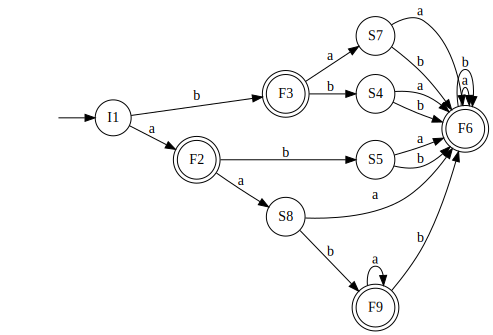

In [62]:
DOblimp

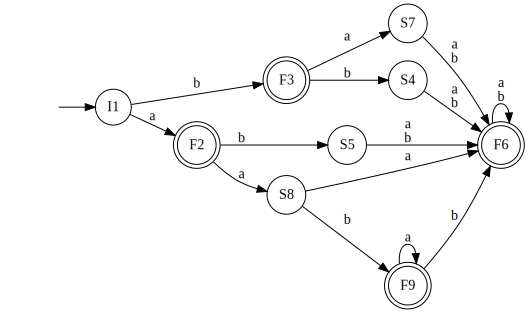

In [63]:
dotObj_dfa(blimp, FuseEdges=True)

# Classical minimization results in the following

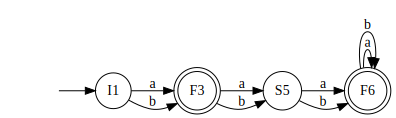

In [64]:
classic_min = min_dfa(blimp)
dotObj_dfa(classic_min)

# Now let's study Brzozowski minimization; its code is a one-liner!

In [65]:
# Brzozowski Minimizer code
def min_dfa_brz(D):
    """Minimize a DFA as per Brzozowski's algorithm.
    """
    return nfa2dfa(rev_dfa(nfa2dfa(rev_dfa(D))))

## Step 1: Reverse the given DFA

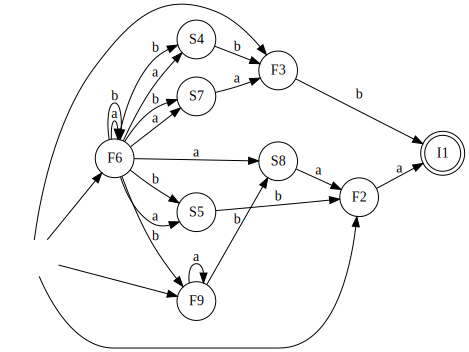

In [66]:
rblimp = rev_dfa(blimp)
DOrblimp = dotObj_nfa(rblimp)
DOrblimp

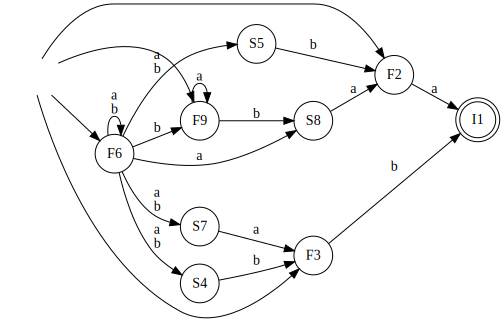

In [67]:
dotObj_nfa(rblimp, FuseEdges=True)

## Step 2: Determinize the result of Step 1

In [68]:
drblimp = nfa2dfa(rblimp)
drblimp

{'Delta': {('St0', 'a'): 'St2',
  ('St0', 'b'): 'St2',
  ('St1', 'a'): 'St0',
  ('St1', 'b'): 'St0',
  ('St2', 'a'): 'St3',
  ('St2', 'b'): 'St3',
  ('St3', 'a'): 'St3',
  ('St3', 'b'): 'St3'},
 'F': {'St0', 'St3'},
 'Q': {'St0', 'St1', 'St2', 'St3'},
 'Sigma': {'a', 'b'},
 'q0': 'St1'}

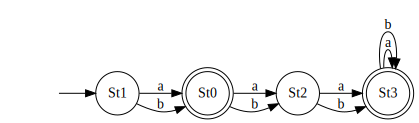

In [69]:
DOdrblimp = dotObj_dfa(drblimp)
DOdrblimp

## Step 3: Reverse the result of Step 2

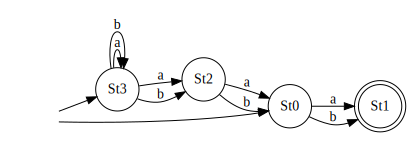

In [70]:
rdrblimp = rev_dfa(drblimp)
DOrdrblimp = dotObj_nfa(rdrblimp)
DOrdrblimp

## Step 4: Determinize the result of Step 3

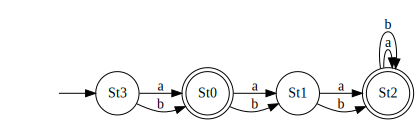

In [71]:
drdrblimp = nfa2dfa(rdrblimp)
DOdrdrblimp = dotObj_dfa(drdrblimp)
DOdrdrblimp

## End result is isomorphic!

In [72]:
iso_dfa(drdrblimp, classic_min)

True

# RE to NFA

Generating LALR tables


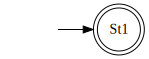

In [73]:
dotObj_nfa(re2nfa("''"))

Generating LALR tables


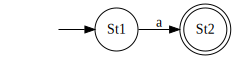

In [74]:
dotObj_nfa(re2nfa("a"))

Generating LALR tables


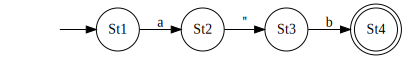

In [75]:
dotObj_nfa(re2nfa("ab"))

Generating LALR tables


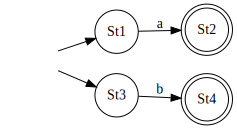

In [76]:
dotObj_nfa(re2nfa("a+b"))

Generating LALR tables


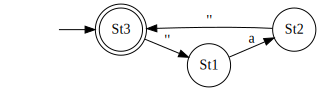

In [77]:
dotObj_nfa(re2nfa("a*"))

Generating LALR tables


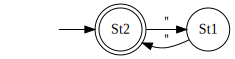

In [78]:
dotObj_nfa(re2nfa("''*"))